In [19]:
import pandas as pd
import numpy as np
from scipy import stats
import sys
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [2]:
train=pd.read_csv('train.csv',sep='|')
test=pd.read_csv('test.csv',sep='|')

Data Preparation: Add features to the data set

In [3]:
train['totalScanTimeInMinutes'] = train['totalScanTimeInSeconds'] / 60.0
train['scannedLineItems'] = train['scannedLineItemsPerSecond'] * train['totalScanTimeInSeconds']
train['pricePerScannedLineItem'] = train['grandTotal'] / train['scannedLineItems']
train['scansWithoutRegistrationPerScannedLineItem'] = train['scansWithoutRegistration'] / train['scannedLineItems']
train['quantityModificationsPerScannedLineItem'] = train['quantityModifications'] / train['scannedLineItems']
train['lineItemVoidsPerSecond'] = train['lineItemVoids'] / train['totalScanTimeInSeconds']
train['scansWithoutRegistrationPerSecond'] = train['scansWithoutRegistration'] / train['totalScanTimeInSeconds']
train['quantityModificationsPerSecond'] = train['quantityModifications'] / train['totalScanTimeInSeconds']
train['secondsPerEuro'] = train['totalScanTimeInSeconds'] / train['grandTotal']
train['lineItemVoidsPerEuro'] = train['lineItemVoids'] / train['grandTotal']
train['scansWithoutRegistrationPerEuro'] = train['scansWithoutRegistration'] / train['grandTotal']
train['quantityModificationsPerEuro'] = train['quantityModifications'] / train['grandTotal']

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Y= train['fraud']
X= train.drop('fraud',axis=1)
x_train, x_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.2, random_state=324)

model= DecisionTreeClassifier(criterion = 'entropy', max_leaf_nodes=8)
model.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=8, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

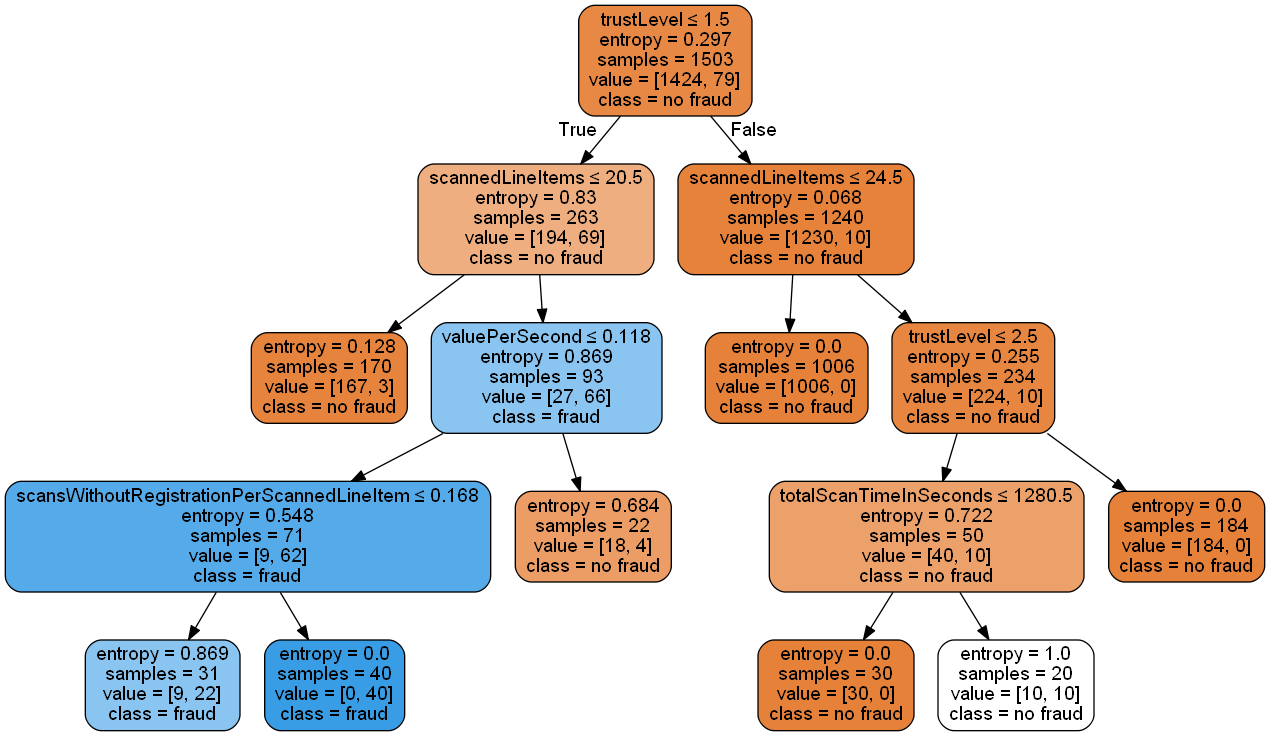

In [9]:
features = list(train.columns.values)
features.remove('fraud')
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = features, class_names=list(['no fraud', 'fraud']))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("Decision Tree.png")
Image(graph.create_png())

In [10]:
from sklearn.metrics import accuracy_score
predictions=model.predict(x_holdout)
accuracy_score(y_true = y_holdout, y_pred = predictions)

0.9654255319148937

In [161]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

def my_custom_loss_func(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    score = ((-25)*fp + (-5)*fn + 5*tp) / len(y_true)
    return (score)

my_custom_score = make_scorer(my_custom_loss_func, greater_is_better=True)
my_custom_loss_func(y_holdout, predictions)

skf = StratifiedKFold(n_splits=30)
loo = LeaveOneOut()

scores = cross_val_score(model, X, Y, cv=skf, scoring=my_custom_score)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: -0.29 (+/- 0.94)


In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_holdout,predictions)
cm

array([[349,   2],
       [ 11,  14]], dtype=int64)

In [37]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_holdout,predictions)

0.7771509971509971

In [38]:
def get_monetary_value(cm, y_holdout):
        tn, fp, fn, tp = cm.ravel()
        print("True negative: ", tn)
        print("False positive: ", fp)
        print("False negative: ", fn)
        print("True positive: ", tp)
        score = (-25)*fp + (-5)*fn + 5*tp
        print(score, 'for ', len(y_holdout), ' instances in the test set')
        print(score/len(y_holdout), ' per instance in the test set')
        return score
        
monetary_value = get_monetary_value(cm, y_holdout)

True negative:  349
False positive:  2
False negative:  11
True positive:  14
-35 for  376  instances in the test set
-0.09308510638297872  per instance in the test set
